# MM Systems, lab 1: basics of JPEG compression

Today, we are going to look more closely at some building blocks in JPEG compression. More specifically, we will apply the DCT to macroblocks in images, use quantization (and optionally subsampling) to reduce the amount of relevant information to be 'encoded' back, and then 'decode' back to examine results.

## What to hand in

To demonstrate you passed this assignment, please submit a pdf to https://www.dropbox.com/request/hM3zs9O9fS2lB5Q9IHVU named <code>[Your_Name].pdf</code> in which you include and discuss the following:
* Two decoded results of the (padded) Lena image with different configurations from the example given below. In terms of 'different configurations', at least change the quantization matrix weights, and include the adjusted matrices in your report. Besides this, you are free to also adjust subsampling techniques or macroblock sizes.
* Two decoded results on an image of your own choice. You are free to reuse the configurations you took for the Lena image. Again, make sure to include quantization matrices and other relevant configuration parameter details in your report.
* With these results and configurations, include a short discussion and explanation on the main differences between decoded results.

## Getting started
First, we will import relevant libraries again.

In [2]:
import numpy as np
import urllib

import cv2

from cvtools import ipynb_show_cv2_image
from cvtools import ipynb_show_matrix
from datasets import CS4065_Dataset

# Don't forget to include this line (only working for iPython notebooks) to use inline plots.
%matplotlib inline

To get a better feel of image sizes, we create a helper function that exposes size parameters.

In [30]:
def parse_numpy_image_size(image_size):
    """
    Usage:
      height, width, channels = parse_numpy_image_size(np.shape(image))
    """
    try:
        height, width, channels = image_size
    except:
        height, width = image_size
        channels = 1
    return height, width, channels


def format_image_size(image_size):
    """
    Usage:
      formatted_image_size = format_image_size(np.shape(image))
    """
    height, width, channels = parse_numpy_image_size(image_size)
    return '%d x %d (%d channels)' % (width, height, channels)

Now we read an image (the Lena image), which already has been pulled automatically into your data folder through Git.
Note that as soon as you will add your own image, you will have to point <code>cv2.imread()</code> to the right local path.

In [ ]:
lena_image_path = CS4065_Dataset.get_testcases_data()['image']
lena_image_original = cv2.imread(lena_image_path)
lena_image_original_size = np.shape(lena_image_original)

# What are the dimensions of this image?
print('original image size: %s' % format_image_size(lena_image_original_size))

We will use square macroblocks for DCT analysis. Let's set it to the default 8x8 size.

In [32]:
# Set macroblocks size.
MACROBLOCK_SIZE = 8

## Handling differently-sized images
The Lena image is 512 x 512 pixels, and as such an integer amount of macroblocks can exactly fit in.

However, if you will use your own images, they might not have such nice dimensions.<br/>
To handle this, we first do a small sub-exercise to ensure an integer amount of macroblocks can be used.

We slightly modify the Lena image dimensions, and will then pad it with black pixels.<br/>
** Use the padded image resulting from this exercise as the basis of the examples in your lab report. **

In [ ]:
# First, crop the image (you will pad it in the next cell).
lena_image_cropped = lena_image_original[:-5, 15:-14, :]
lena_image_cropped_size = np.shape(lena_image_cropped)

print('cropped image size: %s' % format_image_size(lena_image_cropped_size))
ipynb_show_cv2_image(lena_image_cropped)

## Question 1
Complete the <code>pad_image()</code>.

In [ ]:
# Pad the image so that each side is a multiple integer of the macroblock size.

def pad_image(image, block_size=MACROBLOCK_SIZE):
    height, width, channels = parse_numpy_image_size(np.shape(image))

    # TODO: complete the following two lines (add a formula for any input image size).
    padded_height = 0
    padded_width = 0
    assert padded_height >= height and padded_width >= width, (
        (padded_height, height), (padded_width, width))

    padded_image = np.zeros((padded_height, padded_width, channels),
                            dtype=np.uint8)
    padded_image[:height, :width, :] = image
    return padded_image


lena_image = pad_image(lena_image_cropped)
lena_image_size = np.shape(lena_image)
print('cropped image size: %s' % format_image_size(lena_image_size))

# Use this as a checkpoint to verify that you padded correctly.
lena_image_width, lena_image_height, _ = parse_numpy_image_size(
    lena_image_size)
assert 0 == lena_image_width % MACROBLOCK_SIZE and 0 == lena_image_height % MACROBLOCK_SIZE

ipynb_show_cv2_image(lena_image)

## Pixel and macroblock coordinates
We will work with two different indexing mechanisms now: the indices of individual pixels, but also the indices of macroblocks.<br/>
We need to add some code to know what pixels in our image belong to what macroblock.

## Question 2
Given an image, or more in general a (subsampled) channel of an image, we want to know how many macroblocks it has.
For this, we use a function called <code>get_number_of_macroblocks()</code>. You can either use the current implementation of <code>get_number_of_macroblocks()</code> and modify <code>_macroblock_index()</code> or, if you prefer, rewrite <code>get_number_of_macroblocks()</code> from scratch.

In [ ]:
def get_macroblock_coords(xxx_todo_changeme, block_size=MACROBLOCK_SIZE):
    """Computes the macroblock coordinates of a pixel given the (square) block size."""
    (x, y) = xxx_todo_changeme
    def _macroblock_index(pos):
        # This is the core function that does the job for get_number_of_macroblocks().
        # TODO: complete the line below.
        return 0
    return (_macroblock_index(x), _macroblock_index(y))


def get_number_of_macroblocks(image_size, block_size=MACROBLOCK_SIZE):
    """Returns the number of horizontal and vertical macroblocks."""
    return get_macroblock_coords((image_size[1], image_size[0]), block_size)


# Macroblock (0,0).
print(get_macroblock_coords((0, 0)))
print(get_macroblock_coords((0, 7)))
print(get_macroblock_coords((7, 7)))
print(get_macroblock_coords((7, 0)))

# Macroblocks adjacent to (0,0).
print(get_macroblock_coords((8, 0)))
print(get_macroblock_coords((0, 8)))
print(get_macroblock_coords((8, 8)))

print('image size: %s' % format_image_size(lena_image_size))
print(
    'number of macroblocks: %d horizontal and %d vertical' % get_number_of_macroblocks(
        lena_image_size))

## Question 3
You also need to implement <code>macroblock_coords_to_image_vertices()</code>, the function that tells us what region of the image is covered by a macroblock.
The output can be encoded as opposite vertex coordinates of the square region in the image.

In [ ]:
def macroblock_coords_to_image_vertices(macroblock_coords,
                                        block_size=MACROBLOCK_SIZE):
    """Maps a macroblock onto image vertex coordinates."""
    # TODO: complete the four lines below.
    x0 = 0
    y0 = 0
    x1 = 0
    y1 = 0
    return (x0, y0), (x1, y1)


# Let's test your function with the top-left macroblock.
(x0, y0), (x1, y1) = macroblock_coords_to_image_vertices((0, 0))
assert x0 == y0 == 0 and x1 == y1 == MACROBLOCK_SIZE - 1

## Visually check that everything works.
Let's draw a macroblock of a random pixel to check that the output of your functions makes sense.<br/>
Run the cell below multiple times to see the result on different points.

pixel coordinates (477, 187)
macroblock coordinates (14, 5)


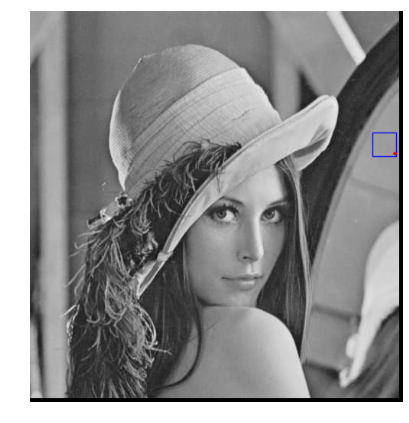

In [51]:
# Let's visualize a macroblock of a random pixel in the image.
# For a better visualization, we temporarily use bigger macroblocks.
BIGGER_MACROBLOCK_SIZE = 32

def get_random_pixel_coords(image_size):
    """Returns random (x, y) coordinates given the image size."""
    return (np.uint16(np.random.randint(0, image_size[1])),
            np.uint16(np.random.randint(0, image_size[0])))


# Get a random pixel.
pixel_coords = get_random_pixel_coords(lena_image_size)
print('pixel coordinates', pixel_coords)

# Get its macroblock coordinates.
macroblock_coords = get_macroblock_coords(pixel_coords, BIGGER_MACROBLOCK_SIZE)
print('macroblock coordinates', macroblock_coords)

# Visualize colored annotations on a gray scale copy of the original image.
lena_image_with_macroblock = cv2.cvtColor(
    cv2.cvtColor(lena_image, cv2.cv.CV_BGR2GRAY), cv2.cv.CV_GRAY2BGR)

# Get the top-left and bottom-right vertex coordinates to draw the macroblock.
(rect_pt1, rect_pt2) = macroblock_coords_to_image_vertices(macroblock_coords,
                                                           BIGGER_MACROBLOCK_SIZE)
cv2.rectangle(lena_image_with_macroblock, rect_pt1, rect_pt2, (255, 0, 0), 1,
              cv2.CV_AA)

# Draw the pixel.
cv2.circle(lena_image_with_macroblock, pixel_coords, 2, (0, 0, 255), -1,
           cv2.CV_AA)

# Show the image.
ipynb_show_cv2_image(lena_image_with_macroblock)

## JPEG image compression
We now will move towards actual compression techniques.

### First step: subsample the YUV channels.
As mentioned in the lecture, JPEG uses the YUV color coordinates, also known as YCbCr (considering chrominance and luminance).<br/>
Luminance is more differentiating than chrominance, so we don't use all chrominance values but average and subsample them (think of the 4:2:2 example in the lecture).

In [56]:
# Parameters (explained below when used for the first time).
USE_ANTIALIASING_FILTER = True
FILTER_SIZE = (2, 2)
SUBSAMPLING_FACTORS = (2, 2)  # Vertical and horizontal.

def subsample_chrominance_channels(image):
    # Let's convert the RGB image to the YUV space.
    # You will apply compression in such color space.
    image_YCrCb = cv2.cvtColor(image, cv2.cv.CV_BGR2YCrCb)

    # Anti-aliasing filter.
    # Before we subsample the Cr and Cb channels, we apply an averaging filter to avoid artifacts.
    # We use cv2.boxFilter() for this (see http://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#boxfilter).
    if USE_ANTIALIASING_FILTER:
        image_Cr_channel_filtered = cv2.boxFilter(image_YCrCb[:, :, 1],
                                                  ddepth=-1, ksize=FILTER_SIZE)
        image_Cb_channel_filtered = cv2.boxFilter(image_YCrCb[:, :, 2],
                                                  ddepth=-1, ksize=FILTER_SIZE)
    else:
        image_Cr_channel_filtered = image_YCrCb[:, :, 1]
        image_Cb_channel_filtered = image_YCrCb[:, :, 2]

    # Subsampling step: we will skip crominance values (similar to image resizing).
    # We use numpy array slicing (see http://docs.scipy.org/doc/numpy/reference/arrays.indexing.html).
    image_Cr_channel_subsampled = image_Cr_channel_filtered[
                                  ::SUBSAMPLING_FACTORS[0],
                                  ::SUBSAMPLING_FACTORS[1]]
    image_Cb_channel_subsampled = image_Cb_channel_filtered[
                                  ::SUBSAMPLING_FACTORS[0],
                                  ::SUBSAMPLING_FACTORS[1]]

    return [
        image_YCrCb[:, :, 0],  # We don't toch the luminance channel.
        image_Cr_channel_subsampled,
        image_Cb_channel_subsampled
    ]


lena_image_YCrCb_subsampled = subsample_chrominance_channels(lena_image)

## Question 4
Subsampling effectively means we are looking at larger, rougher analysis blocks. Also note that the macroblock size does not change, even when a channel is subsampled.

Continue this lab until you have compressed the image with chrominance subsampling - i.e., using <code>subsample_chrominance_channels()</code>. Then come back here, replace <code>lena_image_YCrCb_subsampled</code> with the YCrCb image and recompress the image.
Make sure that you still have a visible copy of the previously compressed image.

**Can you notice differences in visual quality?**

### Second step: define the quantization tables.
Define the quantization tables to use. For now, we will use default values from the original JPEG specification document, looking at 8x8 macroblocks.

In [69]:
# Luminance and chrominance quantization tables.
# (from Annex K of https://www.w3.org/Graphics/JPEG/itu-t81.pdf).

def parse_quantization_table(data):
    return np.array([[
                         np.float64(cell) for cell in row.split(' ')] for row
                     in (
                         data.split('\n'))], dtype=np.float64)


# Quantization table to be used on the Y channel.
JPEG_STANDARD_LUMINANCE_QUANTIZATION_TABLE = parse_quantization_table(
    """16 11 10 16 24 40 51 61
    12 12 14 19 26 58 60 55
    14 13 16 24 40 57 69 56
    14 17 22 29 51 87 80 62
    18 22 37 56 68 109 103 77
    24 35 55 64 81 104 113 92
    49 64 78 87 103 121 120 101
    72 92 95 98 112 100 103 99""")

# Quantization table to be used on the Cr and Cb channels.
JPEG_STANDARD_CHROMINANCE_QUANTIZATION_TABLE = parse_quantization_table(
    """17 18 24 47 99 99 99 99
    18 21 26 66 99 99 99 99
    24 26 56 99 99 99 99 99
    47 66 99 99 99 99 99 99
    99 99 99 99 99 99 99 99
    99 99 99 99 99 99 99 99
    99 99 99 99 99 99 99 99
    99 99 99 99 99 99 99 99""")

In [71]:
# Let's put together the quantization tables of each channel.
quantization_tables = [
    JPEG_STANDARD_LUMINANCE_QUANTIZATION_TABLE,  # Y channel.
    JPEG_STANDARD_CHROMINANCE_QUANTIZATION_TABLE,  # Cr channel.
    JPEG_STANDARD_CHROMINANCE_QUANTIZATION_TABLE,  # Cb channel.
]

### Third step: DCT coefficients quantization.
We will use DCT of 8x8 blocks and quantize the coefficients on the luminance (Y) and chrominance (Cr and Cb) channels.

## Question 5
First, have a look at how <code>quantize_image_YCrCb_dct()</code> is implemented. This function contains the main loop: each block in each channel is indepently compressed via <code>quantizemacroblock_dct</code>.

Your task is implementing <code>quantizemacroblock_dct()</code>. Read the comments in the inline doc to correctly use the passed quantization table.

In [ ]:
def quantizemacroblock_dct(macroblock, quantization_table):
    """
    Quantize DCT coefficients of a macroblock given a quantization table.
    
    DCT coefficients are real values.
    We first scale them (the larger the coefficients in the quantization table,
    the smaller will be the scaled values).
    Finally, we round off the scaled values in order to approximate each coefficient
    to an integer value (quantization process).
    
    The quantized DCT coefficients will be used with loss-less compression techniques
    in order to store them efficiently.
    """
    assert np.shape(macroblock) == np.shape(quantization_table), (
        np.shape(macroblock), np.shape(quantization_table))
    # TODO: no DCT quantization (yet), change the line below.
    return cv2.dct(macroblock)


def quantize_image_YCrCb_dct(
        image_YCrCb_subsampled, scaled_quantization_tables, image_size,
        bln_verbose=True):
    if bln_verbose:
        def _vprint(what):
            print(what)
    else:
        def _vprint(what):
            pass
    _vprint('Quantizing DCT coefficients')

    # Initialization and parameters.  
    image_YCrCb_dct_quantized = []
    block_size = MACROBLOCK_SIZE

    # Each channel is independently processed.
    for channel_index, (channel, quantization_table) in enumerate(
            zip(lena_image_YCrCb_subsampled, scaled_quantization_tables)):

        # Channel properties.
        channel_size = np.shape(channel)
        number_of_horizontal_macroblocks, number_of_vertical_macroblocks = (
            get_number_of_macroblocks(channel_size, block_size))
        quantization_table_data_type = quantization_table.dtype

        _vprint('. channel #%d' % channel_index)
        _vprint('  channel size: %s' % format_image_size(channel_size))
        _vprint('  number of macroblocks: %d x %d' % (
            number_of_horizontal_macroblocks, number_of_vertical_macroblocks))

        # Initialize quantized channel matrix.
        channel_dct_quantized = np.zeros(channel_size,
                                         dtype=quantization_table_data_type)

        # Each macroblock is independently quantized.
        for row in range(number_of_vertical_macroblocks):
            for column in range(number_of_horizontal_macroblocks):
                # Extract the macroblock from the channel matrix.
                (left_top, right_bottom) = macroblock_coords_to_image_vertices(
                    (column, row), block_size)
                macroblock = channel[left_top[1]:right_bottom[1] + 1,
                             left_top[0]:right_bottom[0] + 1]

                # Compute and quantize DCT coefficients.
                macroblock_dct_quantized = quantizemacroblock_dct(
                    macroblock.astype(quantization_table_data_type),
                    quantization_table)

                # Copy macroblock data.
                channel_dct_quantized[
                left_top[1]:right_bottom[1] + 1,
                left_top[0]:right_bottom[0] + 1] = (
                    macroblock_dct_quantized)

        _vprint('  quantized DCT coefficients matrix size: %d x %d' % np.shape(
            channel_dct_quantized))
        image_YCrCb_dct_quantized.append(channel_dct_quantized)

    return image_YCrCb_dct_quantized


lena_image_YCrCb_dct_quantized = quantize_image_YCrCb_dct(
    lena_image_YCrCb_subsampled, quantization_tables, lena_image_size)

### Fourth step: decoding the quantized DCT coefficients.
At this step, <code>lena_image_YCrCb_dct_quantized</code> and <code>quantization_tables</code> are effciently stored into a file using loss-less compression techniques. We don't code this part. Just imagine that <code>lena_image_YCrCb_dct_quantized</code> and <code>quantization_tables</code> are now read by such a compressed file. To reconstruct the image, we need to map the quantized coefficients back to the YUV space (via IDCT and the quantization table) and then convert the decoded image to RGB (for visualization).

## Question 6
Similarly as done for <code>quantize_image_YCrCb_dct()</code>, you now have to complete <code>decode_quantized_dct_block()</code>. Also in this case, start by first checking how the main decompression loop has been implemented in <code>decode_image_YCrCb_dct_quantized()</code>.

In [ ]:
def decode_quantized_dct_block(macroblock_dct_quantized, quantization_table):
    """
    Decode quantized DCT coefficients given the quantization table used at the encoding step.
  
    This function is dual to quantizemacroblock_dct().
    DCT coefficients can be negative, we need to map the macroblock values in the range [0, 255].
    """
    # TODO: change the line below accordingly to your changes in quantizemacroblock_dct().
    macroblock_decoded = cv2.idct(macroblock_dct_quantized)
    return np.clip(macroblock_decoded, 0, 255).astype(np.uint8)


def decode_image_YCrCb_dct_quantized(image_YCrCb_dct_quantized,
                                     scaled_quantization_tables,
                                     image_size, block_size=MACROBLOCK_SIZE,
                                     bln_verbose=True):
    if bln_verbose:
        def _vprint(what):
            print(what)
    else:
        def _vprint(what):
            pass
    _vprint('Decoding quantized DCT')
    pass

    image_height = image_size[0]
    image_width = image_size[1]
    number_of_channels = image_size[2]

    image_YCrCb_decoded = np.zeros(image_size, dtype=np.uint8)
    _vprint('. decoded image size: %d x %d' % (image_width, image_height))

    for channel_index, (
    channel_dct_quantized, quantization_table) in enumerate(
            zip(image_YCrCb_dct_quantized, scaled_quantization_tables)):
        # Channel properties.
        channel_size = np.shape(channel_dct_quantized)
        number_of_horizontal_macroblocks, number_of_vertical_macroblocks = (
            get_number_of_macroblocks(channel_size, block_size))

        _vprint('. channel #%d' % channel_index)
        _vprint('  channel size: %s' % format_image_size(channel_size))
        _vprint('  number of macroblocks: %d x %d' % (
            number_of_horizontal_macroblocks, number_of_vertical_macroblocks))

        # Initialize the decoded channel matrix.
        decoded_channel = np.zeros(channel_size,
                                   dtype=channel_dct_quantized.dtype)

        # Each macroblock is independently decoded.
        for row in range(number_of_vertical_macroblocks):
            for column in range(number_of_horizontal_macroblocks):
                # Extract the macroblock from the quantized DCT coefficients matrix.
                (left_top, right_bottom) = macroblock_coords_to_image_vertices(
                    (column, row), block_size)
                macroblock_dct_quantized = channel_dct_quantized[
                                           left_top[1]:right_bottom[1] + 1,
                                           left_top[0]:right_bottom[0] + 1]

                # Decode quantized DCT coefficients.
                macroblock_decoded = decode_quantized_dct_block(
                    macroblock_dct_quantized, quantization_table)

                # Copy macroblock decoded data.
                decoded_channel[
                left_top[1]:right_bottom[1] + 1,
                left_top[0]:right_bottom[0] + 1] = macroblock_decoded

        # Resize the decoded channel matrix.
        image_YCrCb_decoded[:, :, channel_index] = cv2.resize(decoded_channel,
                                                              (image_width,
                                                               image_height))

    return image_YCrCb_decoded


# Decode, YUV to RGB and compare original and compressed image.
lena_image_YCrCb_decoded = decode_image_YCrCb_dct_quantized(
    lena_image_YCrCb_dct_quantized, quantization_tables, lena_image_size)
lena_image_BGR_decoded = cv2.cvtColor(lena_image_YCrCb_decoded,
                                      cv2.cv.CV_YCrCb2BGR)

ipynb_show_cv2_image(lena_image, 'original')
ipynb_show_cv2_image(lena_image_BGR_decoded, 'compressed')

In [ ]:
# Show the differences in each channel.

def show_image_differences(image0, image1):
    number_of_channels = np.shape(image0)[2]

    for channel_index in range(number_of_channels):
        error = np.abs(
            image0[:, :, channel_index] - image1[:, :, channel_index])
        title = 'error in channel #%d (min: %d, avg: %.1f, max: %d)' % (
            channel_index, np.min(error), np.average(error), np.max(error))
        print(title)
        ipynb_show_matrix(error, title)


show_image_differences(lena_image, lena_image_BGR_decoded)

# Assignment: experiment with the effect of quantization matrices.
Experiment with different values in the luminance and chrominance quantization tables (e.g., try to scale all the values), and discuss effects on the decoded result. Besides this, you are free to also adjust channel subsampling techniques or macroblock sizes.

Use two different images, one has to be "Lena" (available in datasets.CS4065_Dataset) and the second a self-contributed image. Remember to submit a pdf to https://www.dropbox.com/request/hM3zs9O9fS2lB5Q9IHVU named <code>[Your_Name].pdf</code>

### Play with Lena's portrait.

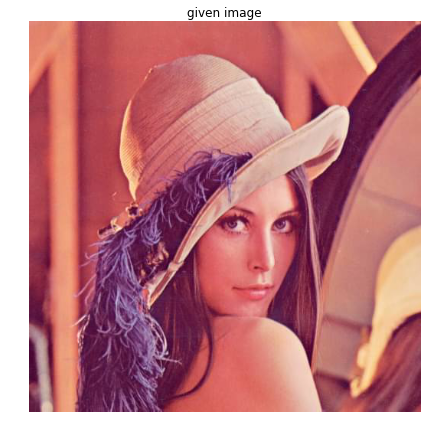

In [14]:
given_image_path = CS4065_Dataset.get_testcases_data()['image']
given_image = cv2.imread(given_image_path)
ipynb_show_cv2_image(given_image, 'given image')

### Now use one of yuor images!
Read the comments below to know hot to use a custom image.

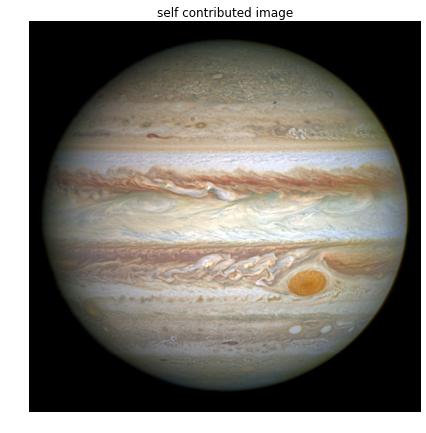

In [15]:
def download_file(url):
    temp_file_path, _ = urllib.request.urlretrieve(url)
    return temp_file_path

# Below you can paste the URL of the image you want to use.
# You can upload on of your images to Dropbox (or similar) and share it publicly to get your URL.
# Make sure that the URL directly points to the image.
# (e.g., with Dropbox use "?dl=1" - by default you get "?dl=0", which does not work here)
image_url = 'https://upload.wikimedia.org/wikipedia/commons/2/2b/Jupiter_and_its_shrunken_Great_Red_Spot.jpg'
self_contributed_image_path = download_file(image_url)
self_contributed_image = cv2.imread(self_contributed_image_path)
ipynb_show_cv2_image(self_contributed_image, 'self contributed image')